From https://pyro.ai/examples/prodlda.html

In [12]:
import pandas as pd
import torch
import numpy as np
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import DataLoader
import random

In [13]:
def get_data(source):
    if source == 'news':
        news = fetch_20newsgroups(subset='all')
        return news['data']
    elif source == 'enron':
        email_data = pd.read_csv('../data/enron/users_data_50_unique_clean_min_10_fixed_sender.tsv', sep='\t', header=None)
        emails = {'data': [], 'sender': [], 'receiver': []}
        for index, row in email_data.iterrows():
            emails['data'].append(row[1])
            emails['labels'].append(row[2])
            emails['receiver'].append(row[3])
        
        return emails['text']
    elif source == 'aal':
        results = {}
        with open('../data/aave/aave_samples.txt', 'r') as f:
            text_data = [x.strip() for x in f.readlines()]
            results['data'] = text_data
            results['labels'] = ['aave' for x in text_data]
        with open('../data/aave/sae_samples.txt', 'r') as f:
            text_data = [x.strip() for x in f.readlines()]
            results['data'] += text_data
            results['labels'] += ['sae' for x in text_data]
        return results



In [14]:
SOURCE = 'aal'

In [15]:

data = get_data(SOURCE)

text_data = data['data']

# vectorizer = CountVectorizer(max_df=0.5, min_df=20, stop_words='english')
vectorizer = CountVectorizer(max_df=0.5, min_df=2, stop_words='english')
docs = torch.from_numpy(vectorizer.fit_transform(text_data).toarray())

label_encoder = LabelEncoder()
label_encoder.fit(data['labels'])
labels = torch.from_numpy(label_encoder.transform(data['labels']))
# make one hot
labels = torch.nn.functional.one_hot(labels)


vocab = pd.DataFrame(columns=['word', 'index'])
vocab['word'] = vectorizer.get_feature_names_out()
vocab['index'] = vocab.index

print('Dictionary size: %d' % len(vocab))
print('Corpus size: {}'.format(docs.shape))

Dictionary size: 4977
Corpus size: torch.Size([4038, 4977])


In [16]:
import math
import torch.nn as nn
import torch.nn.functional as F
import pyro
from pyro.infer import SVI, TraceMeanField_ELBO
from tqdm import trange
import pyro
import pyro.distributions as dist
# from pyro.infer import MCMC, NUTS

In [17]:
class Encoder(nn.Module):
    # Base class for the encoder net, used in the guide
    def __init__(self, vocab_size, num_topics, hidden, dropout, meta_data_size=0):
        super().__init__()
        self.drop = nn.Dropout(dropout)  # to avoid component collapse

        if meta_data_size > 0:
            self.fc1 = nn.Linear(meta_data_size, hidden)
            self.fc1 = nn.Linear(vocab_size+meta_data_size, hidden)
        else:
            self.fc1 = nn.Linear(vocab_size, hidden)
       
        self.fc2 = nn.Linear(hidden, hidden)
        self.fcmu = nn.Linear(hidden, num_topics)
        self.fclv = nn.Linear(hidden, num_topics)
        # NB: here we set `affine=False` to reduce the number of learning parameters
        # See https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html
        # for the effect of this flag in BatchNorm1d
        self.bnmu = nn.BatchNorm1d(num_topics, affine=False)  # to avoid component collapse
        self.bnlv = nn.BatchNorm1d(num_topics, affine=False)  # to avoid component collapse

    def forward(self, inputs, meta_data=None):
        if meta_data is not None:
            meta_data = meta_data.view(inputs.shape[0], -1)
            inputs = torch.cat((inputs, meta_data), dim=1)
        
        h = F.softplus(self.fc1(inputs))
        h = F.softplus(self.fc2(h))
        h = self.drop(h)
        # μ and Σ are the outputs
        logtheta_loc = self.bnmu(self.fcmu(h))
        logtheta_logvar = self.bnlv(self.fclv(h))
        logtheta_scale = (0.5 * logtheta_logvar).exp()  # Enforces positivity
        return logtheta_loc, logtheta_scale


class Decoder(nn.Module):
    # Base class for the decoder net, used in the model
    def __init__(self, vocab_size, num_topics, dropout, num_style_topics=0):
        super().__init__()
        self.beta = nn.Linear(num_topics, vocab_size, bias=False)
        if num_style_topics > 0:
            self.beta_style = nn.Linear(num_style_topics, vocab_size, bias=False)
        self.bn = nn.BatchNorm1d(vocab_size, affine=False)
        self.drop = nn.Dropout(dropout)

    def forward(self, inputs, inputs_style=None):
        inputs = self.drop(inputs)
        if inputs_style is not None:
            inputs_style = self.drop(inputs_style)
            return F.softmax(self.bn(self.beta(inputs) + self.beta_style(inputs_style)), dim=1)
        
        return F.softmax(self.bn(self.beta(inputs)), dim=1)

        # the output is σ(βθ)
        # return F.softmax(self.bn(self.beta(inputs)), dim=1) 
       
class ProdLDA(nn.Module):
    def __init__(self, vocab_size, num_topics, hidden, dropout, num_style_topics=2, meta_length=0, meta_vocab_size=0):
        super().__init__()
        self.vocab_size = vocab_size
        self.meta_vocab_size = meta_vocab_size
        self.meta_length = meta_length
        self.num_topics = num_topics
        self.num_style_topics = num_style_topics
        self.encoder = Encoder(vocab_size, num_topics, hidden, dropout)
        self.encoder_style = Encoder(vocab_size+meta_length, num_style_topics, hidden, dropout)

        self.decoder = Decoder(vocab_size, num_topics, dropout, num_style_topics=self.num_style_topics)
        self.meta_decoder = Decoder(meta_vocab_size, num_topics=self.num_style_topics, dropout=dropout, num_style_topics=0)

    def model(self, docs, meta_data=None):
        pyro.module("decoder", self.decoder)
        pyro.module("meta_decoder", self.meta_decoder)
        with pyro.plate("documents", docs.shape[0]):
            # Dirichlet prior 𝑝(𝜃|𝛼) is replaced by a logistic-normal distribution
            logtheta_loc = docs.new_zeros((docs.shape[0], self.num_topics))
            logtheta_scale = docs.new_ones((docs.shape[0], self.num_topics))
            logtheta = pyro.sample(
                "logtheta", dist.Normal(logtheta_loc, logtheta_scale).to_event(1))
            theta = F.softmax(logtheta, -1)

            logtheta_loc_style = docs.new_zeros((docs.shape[0], self.num_style_topics))
            
            # Use higher variance for style topics
            logtheta_scale_style = docs.new_ones((docs.shape[0], self.num_style_topics))*20
            logtheta_style = pyro.sample(
                "logtheta_style", dist.Normal(logtheta_loc_style, logtheta_scale_style).to_event(1))
            theta_style = F.softmax(logtheta_style, -1)

            # conditional distribution of 𝑤𝑛 is defined as
            # 𝑤𝑛|𝛽,𝜃 ~ Categorical(𝜎(𝛽𝜃))
            count_param = self.decoder(theta, theta_style)
            # Currently, PyTorch Multinomial requires `total_count` to be homogeneous.
            # Because the numbers of words across documents can vary,
            # we will use the maximum count accross documents here.
            # This does not affect the result because Multinomial.log_prob does
            # not require `total_count` to evaluate the log probability.
            total_count = int(docs.sum(-1).max())
            pyro.sample(
                'obs',
                dist.Multinomial(total_count, count_param),
                obs=docs
            )
            if meta_data is not None:
                count_param_meta = self.meta_decoder(theta_style)
                total_count = int(meta_data.sum(-1).max())
                pyro.sample(
                    'meta_data',
                    dist.Multinomial(total_count, count_param_meta),
                    obs=meta_data,
                )

    def guide(self, docs, meta_data=None):
        pyro.module("encoder", self.encoder)
        pyro.module("encoder_style", self.encoder_style)
        with pyro.plate("documents", docs.shape[0]):
            # Dirichlet prior 𝑝(𝜃|𝛼) is replaced by a logistic-normal distribution,
            # where μ and Σ are the encoder network outputs
            logtheta_loc, logtheta_scale = self.encoder(docs)
            logtheta = pyro.sample(
                "logtheta", dist.Normal(logtheta_loc, logtheta_scale).to_event(1))
            
            logtheta_loc_style, logtheta_scale_style = self.encoder_style(docs, meta_data=meta_data)
            logtheta_style = pyro.sample(
                "logtheta_style", dist.Normal(logtheta_loc_style, logtheta_scale_style).to_event(1))
        
        return logtheta, logtheta_style

    def beta(self):
        # beta matrix elements are the weights of the FC layer on the decoder
        return (self.decoder.beta.weight.cpu().detach().T, self.decoder.beta_style.weight.cpu().detach().T)

In [18]:
smoke_test = False

In [19]:
# setting global variables
seed = 0
torch.manual_seed(seed)
pyro.set_rng_seed(seed)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

num_topics = 20 #20 #20 if not smoke_test else 3
docs = docs.float().to(device)
labels = labels.float().to(device)
batch_size = 64
learning_rate = 1e-2 #1e-3
num_epochs = 50 #150 #25 #50 if not smoke_test else 1

In [20]:


# training
pyro.clear_param_store()

prodLDA = ProdLDA(
    vocab_size=docs.shape[1],
    num_topics=num_topics,
    hidden=100, #100 if not smoke_test else 10,
    dropout=0.0, #0.2,
    num_style_topics=2,
    meta_length=label_encoder.classes_.shape[0],
    meta_vocab_size=label_encoder.classes_.shape[0]
)
prodLDA.to(device)

optimizer = pyro.optim.Adam({"lr": learning_rate})
svi = SVI(prodLDA.model, prodLDA.guide, optimizer, loss=TraceMeanField_ELBO())
num_batches = int(math.ceil(docs.shape[0] / batch_size)) if not smoke_test else 1

batch_labels = list(zip(docs, labels))
data_loader = DataLoader(batch_labels, batch_size=batch_size, shuffle=True)

bar = trange(num_epochs)
for epoch in bar:
    running_loss = 0.0
  
    # shuffle data

    for batch_docs, batch_labels in data_loader:
        loss = svi.step(batch_docs, batch_labels)
        running_loss += loss / batch_docs.size(0)

    # for i in batches:
    #     batch_docs = docs[i * batch_size:(i + 1) * batch_size, :]
    #     batch_labels = labels[i * batch_size:(i + 1) * batch_size, :]
        # print(batch_docs.shape)
        # print(batch_labels.shape)
        # loss = svi.step(batch_docs, batch_labels)
        # running_loss += loss / batch_docs.size(0) 
 
    bar.set_postfix(epoch_loss='{:.2e}'.format(running_loss)) 

100%|██████████| 50/50 [00:44<00:00,  1.12it/s, epoch_loss=4.42e+03]


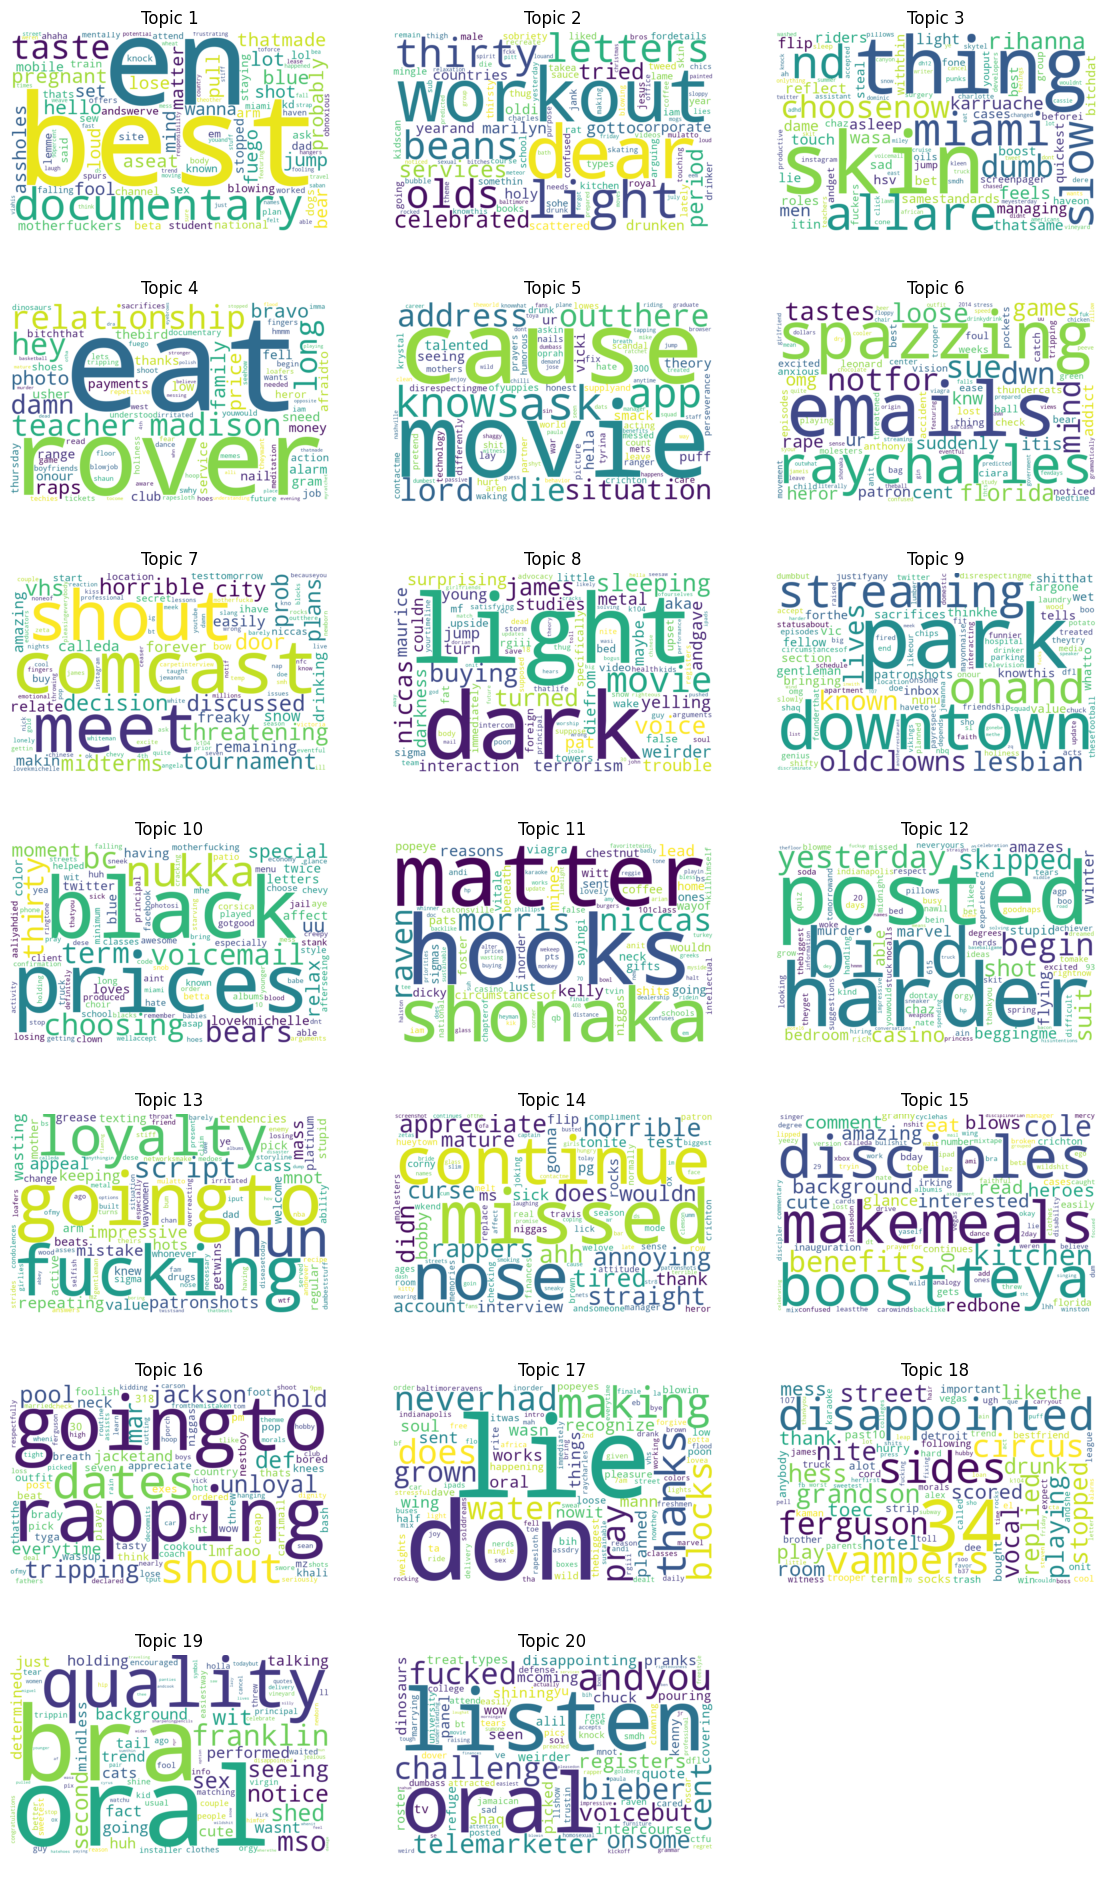

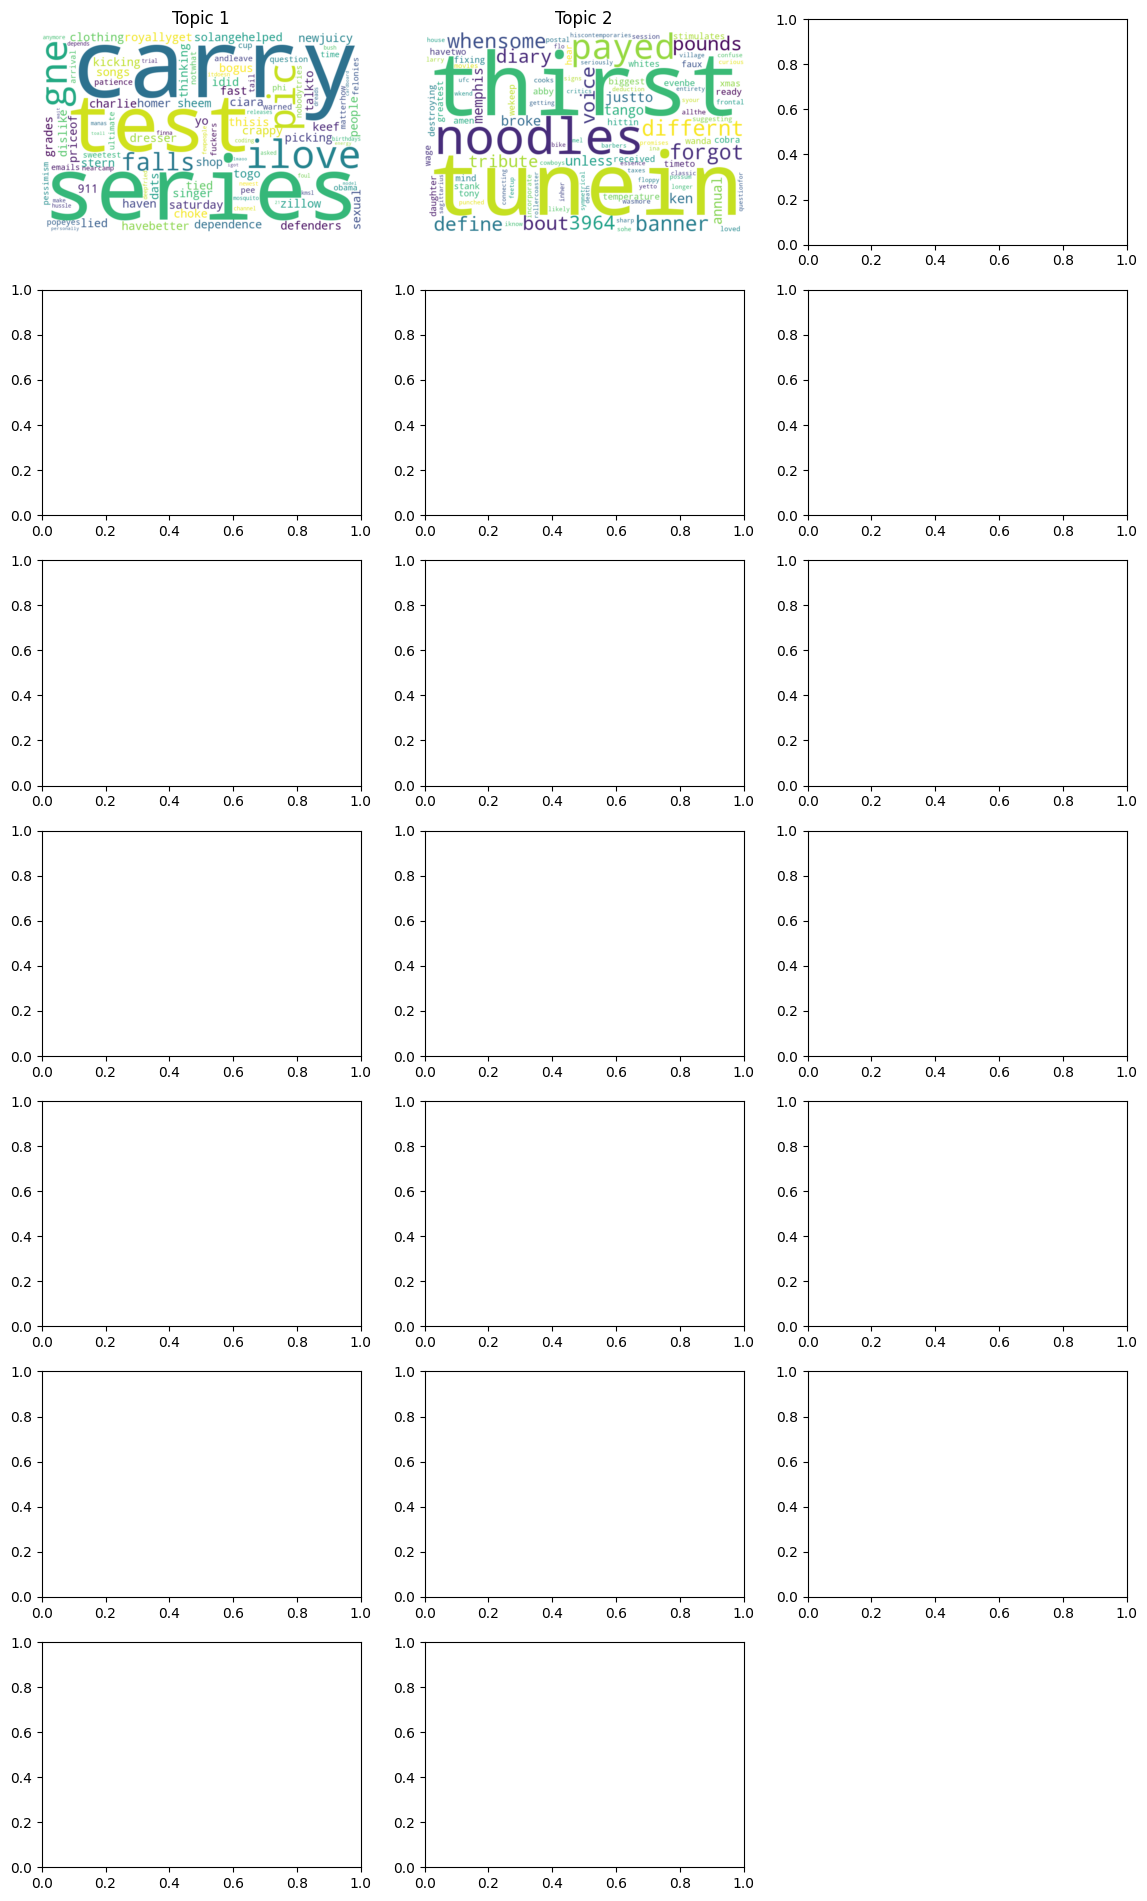

In [21]:
from wordcloud import WordCloud
def plot_word_cloud(b, ax, v, n):
    sorted_, indices = torch.sort(b, descending=True)
    df = pd.DataFrame(indices[:100].numpy(), columns=['index'])
    words = pd.merge(df, vocab[['index', 'word']],
                     how='left', on='index')['word'].values.tolist()
    sizes = (sorted_[:100] * 1000).int().numpy().tolist()
    freqs = {words[i]: sizes[i] for i in range(len(words))}
    wc = WordCloud(background_color="white", width=800, height=500)
    wc = wc.generate_from_frequencies(freqs)
    ax.set_title('Topic %d' % (n + 1))
    ax.imshow(wc, interpolation='bilinear')
    ax.axis("off")

if not smoke_test:
    import matplotlib.pyplot as plt
    from wordcloud import WordCloud

    beta, beta_style = prodLDA.beta()
    fig, axs = plt.subplots(7, 3, figsize=(14, 24))
    for n in range(beta.shape[0]):
        i, j = divmod(n, 3)
        plot_word_cloud(beta[n], axs[i, j], vocab, n)
    axs[-1, -1].axis('off');

    plt.savefig(f'{SOURCE}_wordcloud_beta.png')
    # plt.show()
    fig, axs = plt.subplots(7, 3, figsize=(14, 24))
    for n in range(beta_style.shape[0]):
        i, j = divmod(n, 3)
        plot_word_cloud(beta_style[n], axs[i, j], vocab, n)
    axs[-1, -1].axis('off');

    plt.savefig(f'{SOURCE}_wordcloud_beta_style.png')
    # plt.show()


In [25]:
prodLDA.eval()

label_to_topic = {}
label_to_max = {}

for d, text, encoded_label, label in zip(docs, data['data'], labels, data['labels']):
    if label not in label_to_topic:
        label_to_topic[label] = []
        label_to_max[label] = []
    # print(d)
    # print(label)
    # print('------------------')
    result =  F.softmax(prodLDA.guide(d.unsqueeze(0), encoded_label.unsqueeze(0))[1])

    # argmax = torch.argmax(result)
    # print(argmax)
    label_to_max[label].append(result[0].detach().cpu().numpy())
    print(label, result)
    label_to_topic[label].append((text,result))


for label in label_to_topic:
    print(label, np.mean(label_to_max[label]))

    

/var/folders/3v/_0f8bhv10g34fgybfm73215m0000gq/T/ipykernel_3837/2165163894.py:13: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  result =  F.softmax(prodLDA.guide(d.unsqueeze(0), encoded_label.unsqueeze(0))[1])


aave tensor([[0.0042, 0.9958]], grad_fn=<SoftmaxBackward0>)
aave tensor([[0.0295, 0.9705]], grad_fn=<SoftmaxBackward0>)
aave tensor([[0.0830, 0.9170]], grad_fn=<SoftmaxBackward0>)
aave tensor([[0.0165, 0.9835]], grad_fn=<SoftmaxBackward0>)
aave tensor([[0.3926, 0.6074]], grad_fn=<SoftmaxBackward0>)
aave tensor([[0.4260, 0.5740]], grad_fn=<SoftmaxBackward0>)
aave tensor([[0.6694, 0.3306]], grad_fn=<SoftmaxBackward0>)
aave tensor([[0.1012, 0.8988]], grad_fn=<SoftmaxBackward0>)
aave tensor([[0.7066, 0.2934]], grad_fn=<SoftmaxBackward0>)
aave tensor([[0.0230, 0.9770]], grad_fn=<SoftmaxBackward0>)
aave tensor([[0.7256, 0.2744]], grad_fn=<SoftmaxBackward0>)
aave tensor([[0.9838, 0.0162]], grad_fn=<SoftmaxBackward0>)
aave tensor([[0.9356, 0.0644]], grad_fn=<SoftmaxBackward0>)
aave tensor([[0.0203, 0.9797]], grad_fn=<SoftmaxBackward0>)
aave tensor([[0.9958, 0.0042]], grad_fn=<SoftmaxBackward0>)
aave tensor([[0.9876, 0.0124]], grad_fn=<SoftmaxBackward0>)
aave tensor([[0.4214, 0.5786]], grad_fn=

In [23]:
print('AAL Versions:')
print(label_to_topic['aave'][:5])
print('SAE Versions:')
print(label_to_topic['sae'][:5])

AAL Versions:
[("Sooo Manti Te'o was having a online/phone relationship with a guy pretendingto be a female -_-", tensor([[0.3293, 0.6707]], grad_fn=<SoftmaxBackward0>)), ('this lil girl aint going to win im the king of thisshe better fall back ....', tensor([[0.0353, 0.9647]], grad_fn=<SoftmaxBackward0>)), ("He up stairs rights now and I'm down here getting ready its aboutto go down nite nite", tensor([[0.0091, 0.9909]], grad_fn=<SoftmaxBackward0>)), ("Shit I Am Who Am..Fresh up out of Apologize..I'm Doing It For SHAQ & My KIDS That's MY ATTITUDE THIS YEAROR MOVE THE FUCK AROUND", tensor([[0.0138, 0.9862]], grad_fn=<SoftmaxBackward0>)), ("It's very rare that I get what I want. Now that it has happened I don't plan onloosing it no matter what", tensor([[0.0431, 0.9569]], grad_fn=<SoftmaxBackward0>))]
SAE Versions:
[("Manti Te'o was having a relationship via telephone/internet with a man pretending to be female.", tensor([[0.1252, 0.8748]], grad_fn=<SoftmaxBackward0>)), ('The little gir

In [24]:
prodLDA.meta_decoder.beta.weight

Parameter containing:
tensor([[ 1.3959, -0.3809],
        [ 0.2614, -0.0249]], requires_grad=True)